In [1]:
# import the necessary libraries and modules for the analysis and visualization of the data
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# read male and female submission
male_submission = pd.read_csv('/home/haters/Downloads/Toxicity_Detection/output_perspective/output_score/male_submissions_outcome_final.csv')
female_submission = pd.read_csv('/home/haters/Downloads/Toxicity_Detection/output_perspective/output_score/female_submissions_outcome_final.csv')

In [4]:
# define the function to plot the distribution of scores as percentage histograms
def plot_score_distribution(dataframe, score_columns, bins=20, range=(0, 1), color='b'):
    """
    Plots the distribution of scores as percentage histograms.
    
    Parameters:
        dataframe (pd.DataFrame): The input data frame containing the scores.
        score_columns (list of str): List containing the names of the score columns to plot.
        bins (int): Number of bins for the histogram.
        range (tuple): The range of the histogram bins.
    """
    if len(score_columns) != 2:
        raise ValueError("score_columns list must contain exactly two column names.")
    plt.figure(figsize=(18, 6))
    for i, score_column in enumerate(score_columns, 1):
        plt.subplot(1, 2, i)
        counts, bin_edges, _ = plt.hist(dataframe[score_column], bins=bins, range=range, edgecolor='k', alpha=0.7)
        percentages = counts / len(dataframe[score_column]) * 100
        plt.cla()
        plt.bar(bin_edges[:-1], percentages, width=(bin_edges[1] - bin_edges[0]), edgecolor='k', color = color, alpha=0.7)
        plt.xlabel(f'{score_column.replace("_", " ").title()}', fontsize=14)
        plt.ylabel('Percentage (%)', fontsize=14)
        plt.title(f'The Initial Distribution of {score_column.replace("_", " ").title()}', fontsize=14)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()

#### Male Submission - Initial Score Distribution

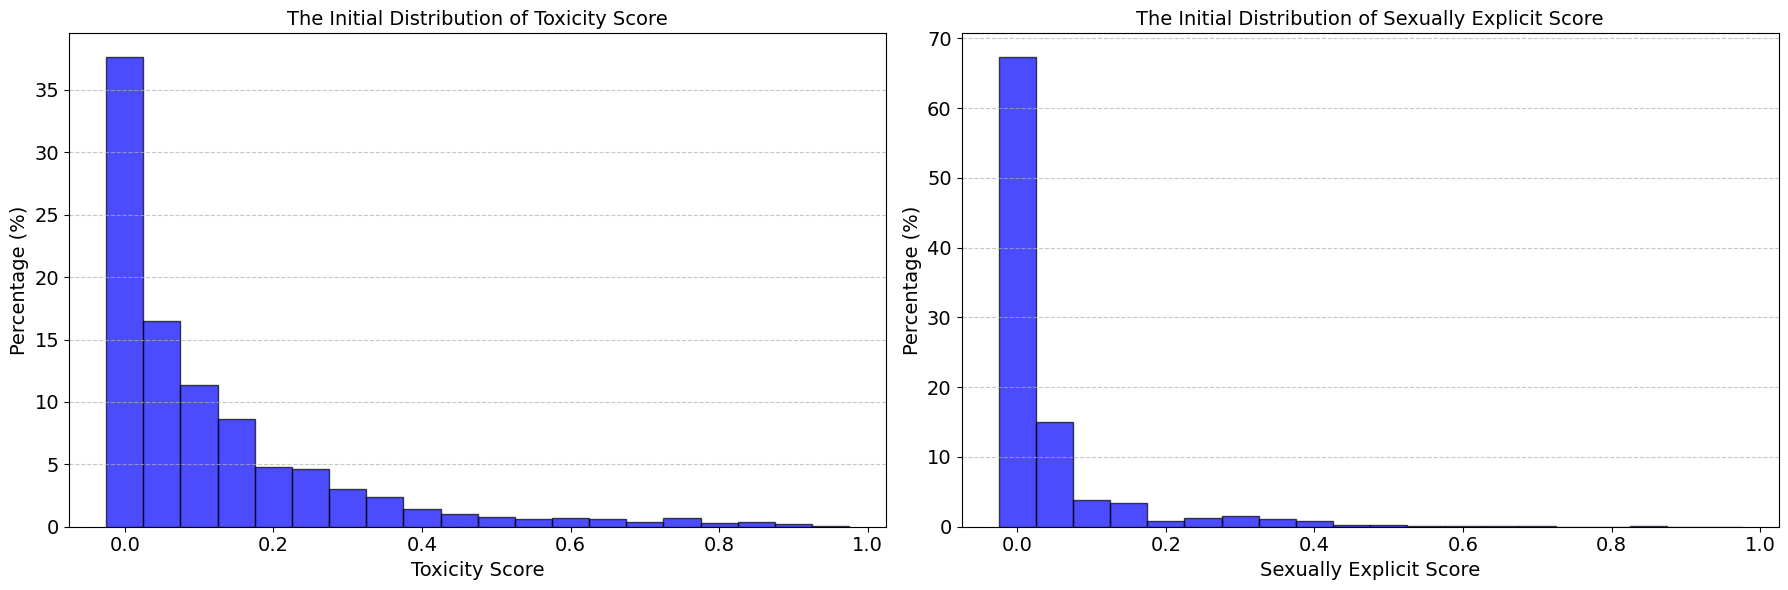

In [5]:
# distribution of scores male submission
plot_score_distribution(male_submission, ['toxicity_score', 'sexually_explicit_score'])

#### Female Submission - Initial Score Distribution

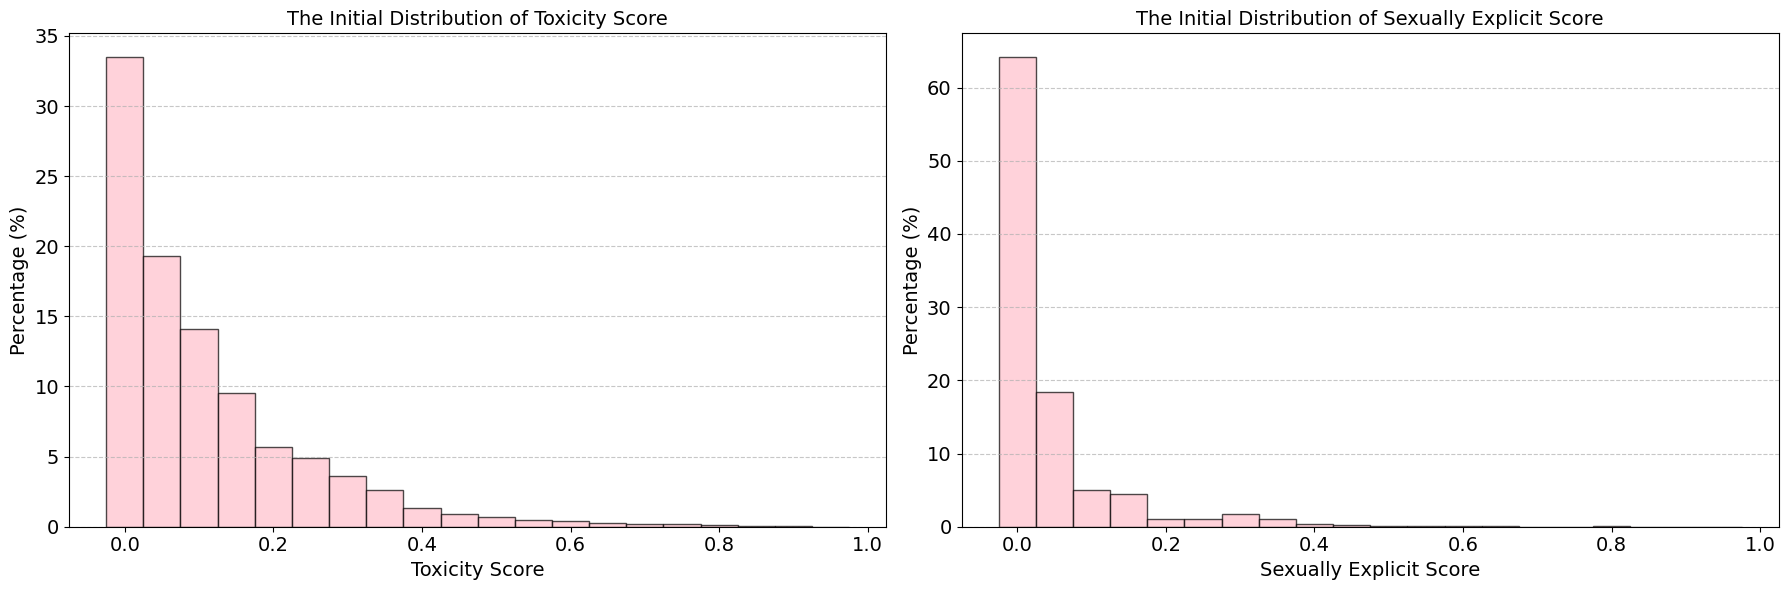

In [6]:
# distribution of scores female submission
plot_score_distribution(female_submission, ['toxicity_score', 'sexually_explicit_score'], color = 'pink')

#### Filter toxicity_score > 0.5  and sexually_explicit_score >0.5
##### this threshold value is just an initial one

In [7]:
# filter toxicity_score > 0.5  and sexually_explicit_score >0.5 this threshold value is just an initial one
male_submission_filtered = male_submission[(male_submission['toxicity_score'] > 0.5) | (male_submission['sexually_explicit_score'] > 0.5)]
female_submission_filtered = female_submission[(female_submission['toxicity_score'] > 0.5) | (female_submission['sexually_explicit_score'] > 0.5)]

In [8]:
print(male_submission_filtered.shape[0])
print (female_submission_filtered.shape[0])

743
835


In [9]:
print(male_submission_filtered[male_submission_filtered['toxicity_score'] > 0.5].shape[0])
print(male_submission_filtered[male_submission_filtered['sexually_explicit_score'] > 0.5].shape[0])


731
115


In [10]:
print(female_submission_filtered[female_submission_filtered['toxicity_score'] > 0.5].shape[0])
print(female_submission_filtered[female_submission_filtered['sexually_explicit_score'] > 0.5].shape[0])

829
157


- For male submission, 743 (**4.75%**)  rows were selected when use 0.5 as a threshold value for both labels,
- among them, 731 were toxic (**4.67%**), 115 were sexually explicit (**0.73%**)
- For female submission, 835 (**2.40%**) rows were selected when use 0.5 as a threshold value for both labels
- among them, 829 were toxic (**2.39%**), 157 were sexually explicit (**0.45%**)


In [11]:
# define the function to plot the distribution of scores as percentage histograms per artist
def plot_artist_score_distribution(male_s_df, male_s_filtered_df, score_columns, threshold=0.5, bins=20, range=(0, 1), colors=['orange', 'red']):
    """
    Plots the distribution of toxicity and sexually explicit scores as percentage histograms per artist.
    
    Parameters:
        male_s_df (pd.DataFrame): The original data frame containing the scores.
        male_s_filtered_df (pd.DataFrame): The filtered data frame containing the scores above certain threshold.
        score_columns (list of str): List containing the names of the score columns to plot.
        threshold (float): The threshold value to filter scores.
        bins (int): Number of bins for the histogram.
        range (tuple): The range of the histogram bins.
        colors (list of str): List of colors for the bars in the histogram.
    """
    if len(score_columns) != 2:
        raise ValueError("score_columns list must contain exactly two column names.")
    
    # get the original total rows of each artist
    sub_counts = male_s_df.groupby('artist').size().reset_index(name='sub_counts')

    # get the total rows of each artist after filtering
    grouped = male_s_filtered_df.groupby('artist').size().reset_index(name='toxic_and_sexual_counts')
    toxicity_counts = male_s_filtered_df[male_s_filtered_df[score_columns[0]] > threshold].groupby('artist').size().reset_index(name='toxicity_counts')
    sexually_explicit_counts = male_s_filtered_df[male_s_filtered_df[score_columns[1]] > threshold].groupby('artist').size().reset_index(name='sexually_explicit_counts')

    # merge
    merged_counts = pd.merge(grouped, sub_counts, on='artist', how='left')
    merged_counts = pd.merge(merged_counts, toxicity_counts, on='artist', how='left')
    merged_counts = pd.merge(merged_counts, sexually_explicit_counts, on='artist', how='left')

    # NaN = 0
    merged_counts.fillna(0, inplace=True)

    # Calculate percentages
    merged_counts['toxicity_percentage'] = (merged_counts['toxicity_counts'] / merged_counts['sub_counts']) * 100
    merged_counts['sexually_explicit_percentage'] = (merged_counts['sexually_explicit_counts'] / merged_counts['sub_counts']) * 100

    
    plt.figure(figsize=(18, 6))

    # toxicity_score > threshold
    plt.subplot(1, 2, 1)
    plt.bar(merged_counts['artist'], merged_counts['toxicity_percentage'], color=colors[0], alpha=0.7)
    plt.xlabel('Artist', fontsize=14)
    plt.ylabel('Percentage (%)', fontsize=14)
    plt.title(f'{score_columns[0].replace("_", " ").title()} > {threshold} per Artist', fontsize=14)
    plt.xticks(rotation=90, fontsize=12)
    plt.yticks(fontsize=14)

    # sexually_explicit_score > threshold
    plt.subplot(1, 2, 2)
    plt.bar(merged_counts['artist'], merged_counts['sexually_explicit_percentage'], color=colors[1], alpha=0.7)
    plt.xlabel('Artist', fontsize=14)
    plt.ylabel('Percentage (%)', fontsize=14)
    plt.title(f'{score_columns[1].replace("_", " ").title()} > {threshold} per Artist', fontsize=14)
    plt.xticks(rotation=90, fontsize=12)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()
    return merged_counts

#### Male Aritists - Submission

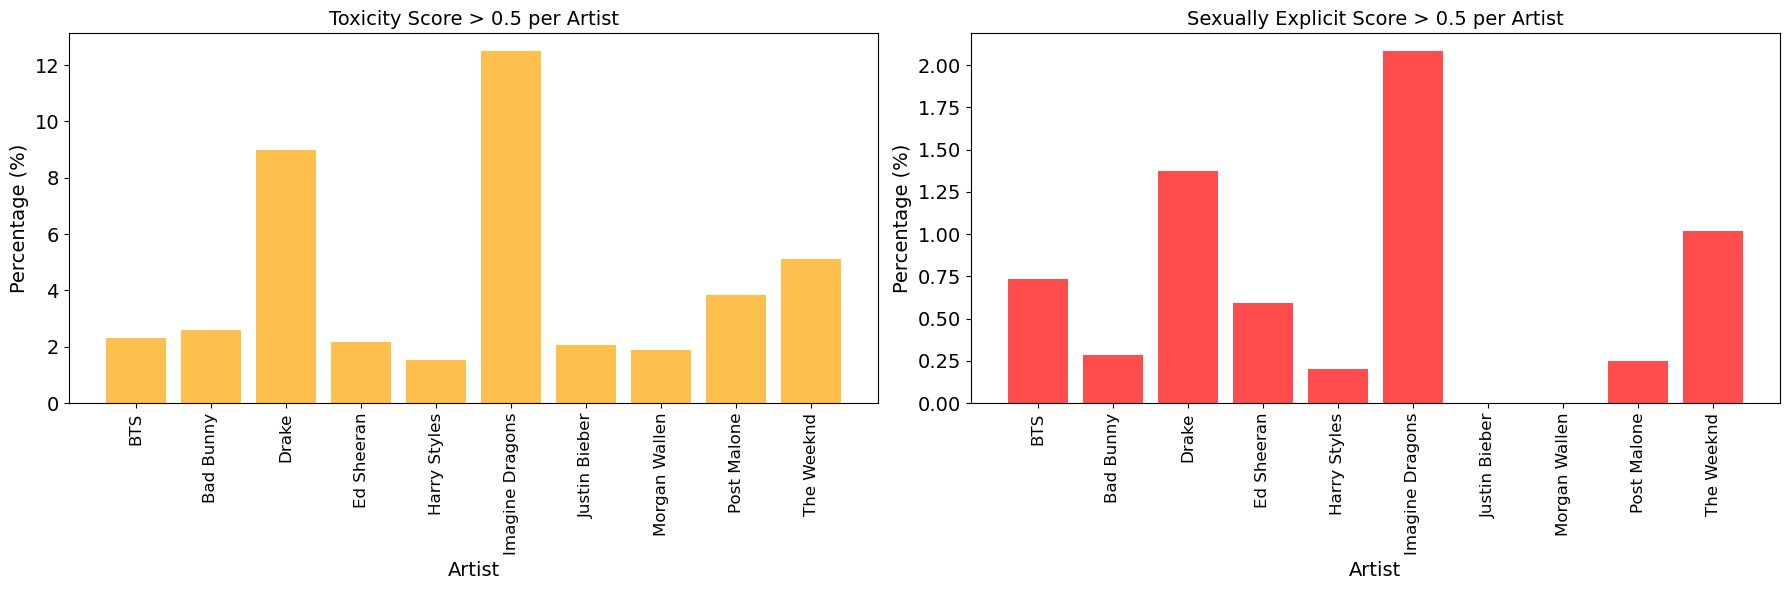

In [12]:
# plot the distribution of toxicity and sexually explicit scores as percentage histograms per artist
merged_counts_male = plot_artist_score_distribution(male_submission, male_submission_filtered, ['toxicity_score', 'sexually_explicit_score'], threshold=0.5, colors=['orange', 'red'])

In [13]:
# calculate the ratio
merged_counts_male['toxicity_percentage'] = (merged_counts_male['toxicity_counts'] / merged_counts_male['sub_counts']) * 100
merged_counts_male['sexually_explicit_percentage'] = (merged_counts_male['sexually_explicit_counts'] / merged_counts_male['sub_counts']) * 100

In [14]:
display(merged_counts_male)

,artist,toxic_and_sexual_counts,sub_counts,toxicity_counts,sexually_explicit_counts,toxicity_percentage,sexually_explicit_percentage
0,BTS,74,2996,69,22.0,2.303071,0.734312
1,Bad Bunny,19,695,18,2.0,2.589928,0.287770
2,Drake,427,4728,425,65.0,8.989002,1.374788
3,Ed Sheeran,51,2197,48,13.0,2.184797,0.591716
4,Harry Styles,15,982,15,2.0,1.527495,0.203666
5,Imagine Dragons,6,48,6,1.0,12.500000,2.083333
6,Justin Bieber,5,240,5,0.0,2.083333,0.000000
7,Morgan Wallen,1,53,1,0.0,1.886792,0.000000
8,Post Malone,140,3618,139,9.0,3.841902,0.248756
9,The Weeknd,5,98,5,1.0,5.102041,1.020408


Drake has received the most **toxic** posts and the most **sexually explicit** submission

#### Female Aritists - Submission

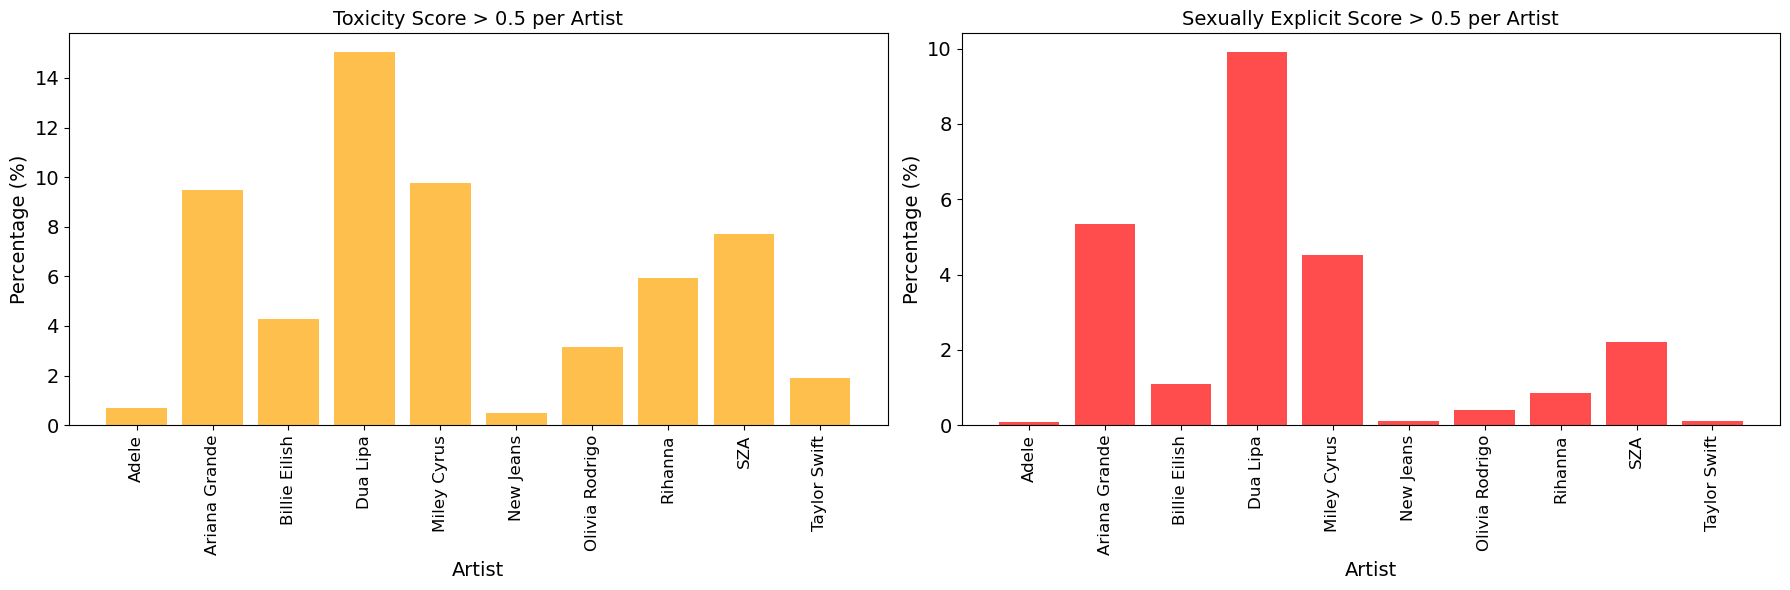

In [15]:
merged_counts_female = plot_artist_score_distribution(female_submission, female_submission_filtered, ['toxicity_score', 'sexually_explicit_score'], threshold=0.5, colors=['orange', 'red'])

In [16]:
merged_counts_female

,artist,toxic_and_sexual_counts,sub_counts,toxicity_counts,sexually_explicit_counts,toxicity_percentage,sexually_explicit_percentage
0,Adele,8,1165,8,1,0.686695,0.085837
1,Ariana Grande,48,506,48,27,9.486166,5.335968
2,Billie Eilish,78,1806,77,20,4.263566,1.107420
3,Dua Lipa,86,565,85,56,15.044248,9.911504
4,Miley Cyrus,14,133,13,6,9.774436,4.511278
5,New Jeans,9,1883,9,2,0.477961,0.106213
6,Olivia Rodrigo,95,3002,95,12,3.164557,0.399734
7,Rihanna,7,118,7,1,5.932203,0.847458
8,SZA,7,91,7,2,7.692308,2.197802
9,Taylor Swift,483,25473,480,30,1.884348,0.117772


TS has received the most **toxic** posts, but Dua Lipa has received the most **sexually explicit** posts


#### Significance test
##### Toxicity

In [3]:
# filter toxicity_score > 0.5 and sexually_explicit_score >0.5 this threshold value is just an initial one
male_submission['is_toxic'] = male_submission['toxicity_score'] > 0.5
female_submission['is_toxic'] = female_submission['toxicity_score'] > 0.5

In [4]:
# calculate the ratio of toxic submission
male_post_summary = male_submission['is_toxic'].value_counts()
female_post_summary = female_submission['is_toxic'].value_counts()
print("Male Submission Summary:\n", male_post_summary)
print("Female Submission Summary:\n", female_post_summary)

Male Submission Summary:
 is_toxic
False    14924
True       731
Name: count, dtype: int64
Female Submission Summary:
 is_toxic
False    33913
True       829
Name: count, dtype: int64


In [5]:
# calculate the ratio of toxic submission
male_toxic_ratio = male_post_summary.get(True, 0) / male_post_summary.sum()
female_toxic_ratio = female_post_summary.get(True, 0) / female_post_summary.sum()

In [6]:
print(f"Male Toxic Submission Ratio: {male_toxic_ratio}")
print(f"Female Toxic Submission Ratio: {female_toxic_ratio}")

Male Toxic Submission Ratio: 0.046694346854040246
Female Toxic Submission Ratio: 0.023861608427839503


In [9]:
# construct the contingency table for Chi-square test
contingency_table = pd.DataFrame({
    'Male': [male_post_summary.get(True, 0), male_post_summary.sum() - male_post_summary.get(True, 0)],
    'Female': [female_post_summary.get(True, 0), female_post_summary.sum() - female_post_summary.get(True, 0)]
}, index=['Toxic', 'Non-toxic'])

# Chi-square test
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f'Chi-square value: {chi2}')
print(f'Chi-square test p-value: {p}')

# z-test
count = [male_post_summary.get(True, 0), female_post_summary.get(True, 0)]
nobs = [male_post_summary.sum(), female_post_summary.sum()]
stat, p_val = proportions_ztest(count, nobs)
print(f'z value: {stat}')
print(f'z-test p-value: {p_val}')

# Fisher's Exact test
contingency_matrix = contingency_table.values
odds_ratio, p_value = fisher_exact(contingency_matrix, alternative='two-sided')


print("Fisher's Exact Test:")
print(f"Odds Ratio: {odds_ratio}")
print(f"P-value: {p_value}")

Chi-square value: 186.80596211211952
Chi-square test p-value: 1.583255143784434e-42
z value: 13.695487618152525
z-test p-value: 1.0803266076332031e-42
Fisher's Exact Test:
Odds Ratio: 2.00375129445564
P-value: 4.725020762232564e-40


- Therefore, a significant relation exists between the gender and the toxic content
- To be specific, z-test shows that the toxic submission ratio is significantlt different among two groups. Male singers received a higher ratio of toxic submission on Reddit than Female singers

## Sexually Explicit

In [10]:
# filter sexually_explicit_score > 0.5 this threshold value is just an initial one
male_submission['is_sexually_explicit'] = male_submission['sexually_explicit_score'] > 0.5
female_submission['is_sexually_explicit'] = female_submission['sexually_explicit_score'] > 0.5

In [11]:
# calculate the ratio of sexually explicit submission
male_post_summary_se = male_submission['is_sexually_explicit'].value_counts()
female_post_summary_se = female_submission['is_sexually_explicit'].value_counts()
print("Male Submission Summary:\n", male_post_summary_se)
print("Female Submission Summary:\n", female_post_summary_se)

Male Submission Summary:
 is_sexually_explicit
False    15540
True       115
Name: count, dtype: int64
Female Submission Summary:
 is_sexually_explicit
False    34585
True       157
Name: count, dtype: int64


In [12]:
# calculate the ratio of sexually explicit submission
male_se_ratio = male_post_summary_se.get(True, 0) / male_post_summary_se.sum()
female_se_ratio = female_post_summary_se.get(True, 0) / female_post_summary_se.sum()
print(f"Male Sexually Explicit Submission Ratio: {male_se_ratio}")
print(f"Female Sexually Explicit Submission Ratio: {female_se_ratio}")

Male Sexually Explicit Submission Ratio: 0.007345895879910571
Female Sexually Explicit Submission Ratio: 0.0045190259628115825


In [14]:
# construct the contingency table for Chi-square test
contingency_table = pd.DataFrame({
    'Male': [male_post_summary_se.get(True, 0), male_post_summary_se.sum() - male_post_summary_se.get(True, 0)],
    'Female': [female_post_summary_se.get(True, 0), female_post_summary_se.sum() - female_post_summary_se.get(True, 0)]
}, index=['Sexually_expliciy', 'Non_sexually_explicit'])

# Chi-square test
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f'Chi-square value: {chi2}')
print(f'Chi-square test p-value: {p}')

# z-test
count = [male_post_summary_se.get(True, 0), female_post_summary_se.get(True, 0)]
nobs = [male_post_summary_se.sum(), female_post_summary_se.sum()]
stat, p_val = proportions_ztest(count, nobs)
print(f'z value: {stat}')
print(f'z-test p-value: {p_val}')

# Fisher's Exact test
contingency_matrix = contingency_table.values
odds_ratio, p_value = fisher_exact(contingency_matrix, alternative='two-sided')


print("Fisher's Exact Test:")
print(f"Odds Ratio: {odds_ratio}")
print(f"P-value: {p_value}")

Chi-square value: 15.543449314389525
Chi-square test p-value: 8.063054832508214e-05
z value: 4.008209986295846
z-test p-value: 6.118071005361883e-05
Fisher's Exact Test:
Odds Ratio: 1.630177720942052
P-value: 9.888242737009831e-05


- Therefore, a significant relation exists between the gender and the sexually explicit content
- To be specific, z-test shows that the sexually explicit submission ratio is significantlt different among two groups. Male singers received a higher ratio of sexually explicit submission on Reddit than Female singers